In [2]:
import pandas as pd
import os

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aljarah/xAPI-Edu-Data")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.54k/5.54k [00:00<00:00, 2.41MB/s]

Extracting files...
Path to dataset files: /Users/francisco/.cache/kagglehub/datasets/aljarah/xAPI-Edu-Data/versions/6


In [4]:
df_path = r"/Users/francisco/.cache/kagglehub/datasets/aljarah/xAPI-Edu-Data/versions/6/xAPI-Edu-Data.csv"
df = pd.read_csv(df_path)
display(df)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,F,Jordan,Jordan,MiddleSchool,G-08,A,Chemistry,S,Father,5,4,5,8,No,Bad,Above-7,L
476,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Father,50,77,14,28,No,Bad,Under-7,M
477,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,S,Father,55,74,25,29,No,Bad,Under-7,M
478,F,Jordan,Jordan,MiddleSchool,G-08,A,History,F,Father,30,17,14,57,No,Bad,Above-7,L


In [ ]:
df.columns

In [6]:
# Reemplazar valores vacíos por NaN
df.replace(["?", "NA", "None", ""], pd.NA, inplace=True)

# Imputar valores numéricos con la media
num_cols = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Imputar categóricos con la moda
cat_cols = [
    'gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID',
    'Topic','Semester','Relation','ParentAnsweringSurvey',
    'ParentschoolSatisfaction','StudentAbsenceDays','Class'
]
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Resultado pandas
print("DataFrame procesado con Pandas:")
print(df.head())



# ================================
#     PREPROCESAMIENTO EN SPARK
# ================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
)

spark = SparkSession.builder.appName("Preprocessing").getOrCreate()

# Convertir pandas → Spark DataFrame
spark_df = spark.createDataFrame(df)

# --- 1. Codificación de variables categóricas ---
categorical_cols = [
    'gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID',
    'Topic','Semester','Relation','ParentAnsweringSurvey',
    'ParentschoolSatisfaction','StudentAbsenceDays','Class'
]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]

# One-Hot Encoder
encoders = [
    OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_oh")
    for c in categorical_cols
]

# --- 2. Columnas numéricas ---
numeric_cols = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']

# Ensamblar características
assembler = VectorAssembler(
    inputCols=[f"{c}_oh" for c in categorical_cols] + numeric_cols,
    outputCol="vector_features"
)

# --- 3. Normalización ---
scaler = MinMaxScaler(inputCol="vector_features", outputCol="scaled_features")



DataFrame procesado con Pandas:
  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20             

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/04 19:43:25 WARN Utils: Your hostname, Franciscos-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
25/12/04 19:43:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/04 19:43:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

# Convertir variable objetivo a numérica
label_indexer = StringIndexer(
    inputCol="Class",
    outputCol="label",
    handleInvalid="keep"
)

# Modelo predictivo
rf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label",
    numTrees=100,
    maxDepth=6
)

# Crear pipeline completo
pipeline = Pipeline(stages=indexers + encoders + [
    assembler, scaler, label_indexer, rf
])


In [8]:
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)


In [9]:
model = pipeline.fit(train_data)


25/12/04 19:44:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
predictions = model.transform(test_data)

predictions.select("label", "prediction", "probability").show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  2.0|       2.0|[0.05949813325863...|
|  2.0|       2.0|[0.09082262626336...|
|  0.0|       0.0|[0.89607783593158...|
|  0.0|       0.0|[0.87377320476441...|
|  0.0|       0.0|[0.92442399300866...|
|  2.0|       2.0|[0.06478222903932...|
|  2.0|       2.0|[0.15522541595590...|
|  1.0|       1.0|[0.13862343880448...|
|  2.0|       2.0|[0.14085571384882...|
|  0.0|       0.0|[0.94759591445169...|
+-----+----------+--------------------+
only showing top 10 rows


In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Precisión del modelo: {accuracy:.4f}")


Precisión del modelo: 1.0000


In [12]:
f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
).evaluate(predictions)

print(f"F1-Score: {f1:.4f}")


F1-Score: 1.0000


In [13]:
pred_pd = predictions.select("label", "prediction").toPandas()


Matplotlib is building the font cache; this may take a moment.


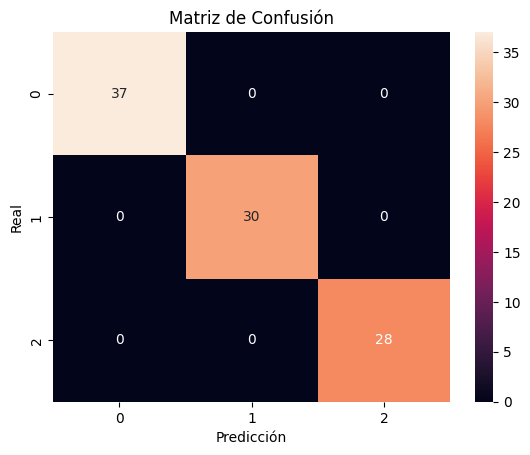

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


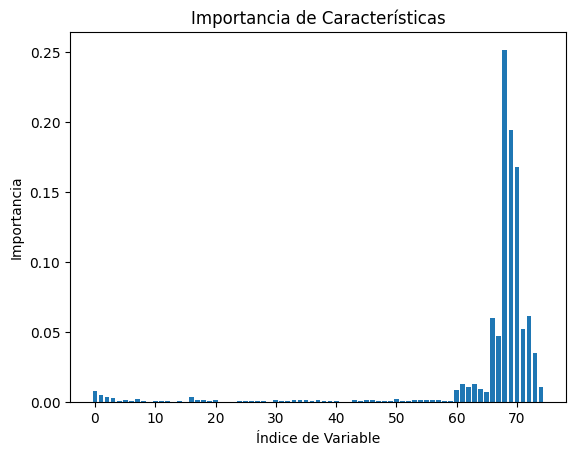

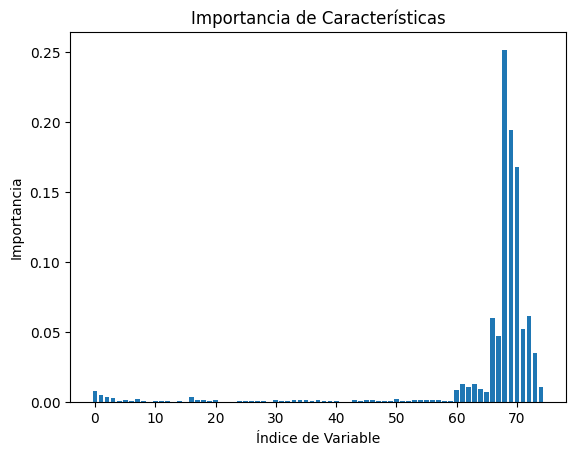

In [15]:
rf_model = model.stages[-1]

importances = rf_model.featureImportances.toArray()

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Importancia de Características")
plt.xlabel("Índice de Variable")
plt.ylabel("Importancia")
plt.show()
rf_model = model.stages[-1]

importances = rf_model.featureImportances.toArray()

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Importancia de Características")
plt.xlabel("Índice de Variable")
plt.ylabel("Importancia")
plt.show()


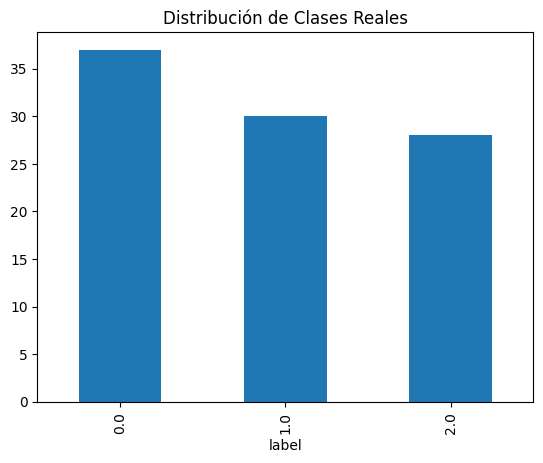

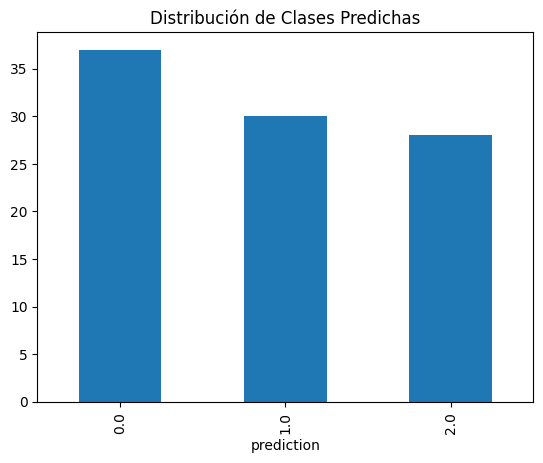

In [16]:
pred_pd["label"].value_counts().plot(kind="bar")
plt.title("Distribución de Clases Reales")
plt.show()

pred_pd["prediction"].value_counts().plot(kind="bar")
plt.title("Distribución de Clases Predichas")
plt.show()
